You will work through an example project end to end, pretending to be a recently hired data scientist at a real estate company. The goal is to illustrate the main steps of a machine learning project, here are the main steps we will walk through:

1. Look at the big picture.
2. Get the data.
3. Explore and visualize the data to gain insights.
4. Prepare the data for machine learning algorithms.
5. Select a model and train it.
6. Fine-tune your model.
7. Present your solution.
8. Launch, monitor, and maintain your system.

# 1. Look at the big picture

Your first task is to use California census data to build a model of housing prices in the state. This data includes metrics such as the population, median income, and median housing price for each block group in California. Block groups are the smallest geographical unit for which the US Census Bureau publishes sample data (a block group typically has a population of 600 to 3,000 people). I will call them “districts” for short.

Your model should learn from this data and be able to predict the median housing price in any district, given all the other metrics.

## Frame the Problem

Knowing the objective is important because it will determine how you frame the problem, which algorithms you will select, which performance measure you will use to evaluate your model, and how much effort you will spend tweaking it. A machine learning pipeline for real estate investments:

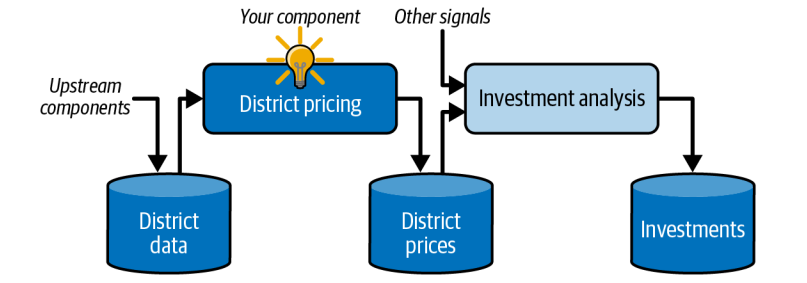

With all this information, you are now ready to start designing your system. First, determine what kind of training supervision the model will need.

## Select a Performance Measure

A typical performance measure for regression problems is the root mean square error (RMSE). It gives an idea of how much error the system typically makes in its predictions, with a higher weight given to large errors:

$$\text{RMSE}(\mathbf{X}, h) = \sqrt{\frac{1}{m}\sum_{i=1}^m[h(\mathbf{x}^{(i)}) - y^{(i)}]^2}$$

Ff there are many outlier districts. In that case, you may consider using the mean absolute error (MAE, also called the average absolute deviation):

$$\text{MAE}(\mathbf{X}, h) = \frac{1}{m}\sum_{i=1}^m|h(\mathbf{x}^{(i)}) - y^{(i)}|$$

## Check the Assumptions

For example, the district prices that your system outputs are going to be fed into a downstream machine learning system, and you assume that these prices are going to be used as such. But what if the downstream system converts the prices into categories (e.g., “cheap”, “medium”, or “expensive”) and then uses those categories instead of the prices themselves? In this case, getting the price perfectly right is not important at all; your system just needs to get the category right. If that’s so, then the problem should have been framed as a classification task, not a regression task.

# 2. Get the data

## Download the Data

In [1]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

## Take a Quick Look at the Data Structure

In [2]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [4]:
# extra code – code to save the figures as high-res PNGs for the book

IMAGES_PATH = Path() / "images" / "end_to_end_project"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

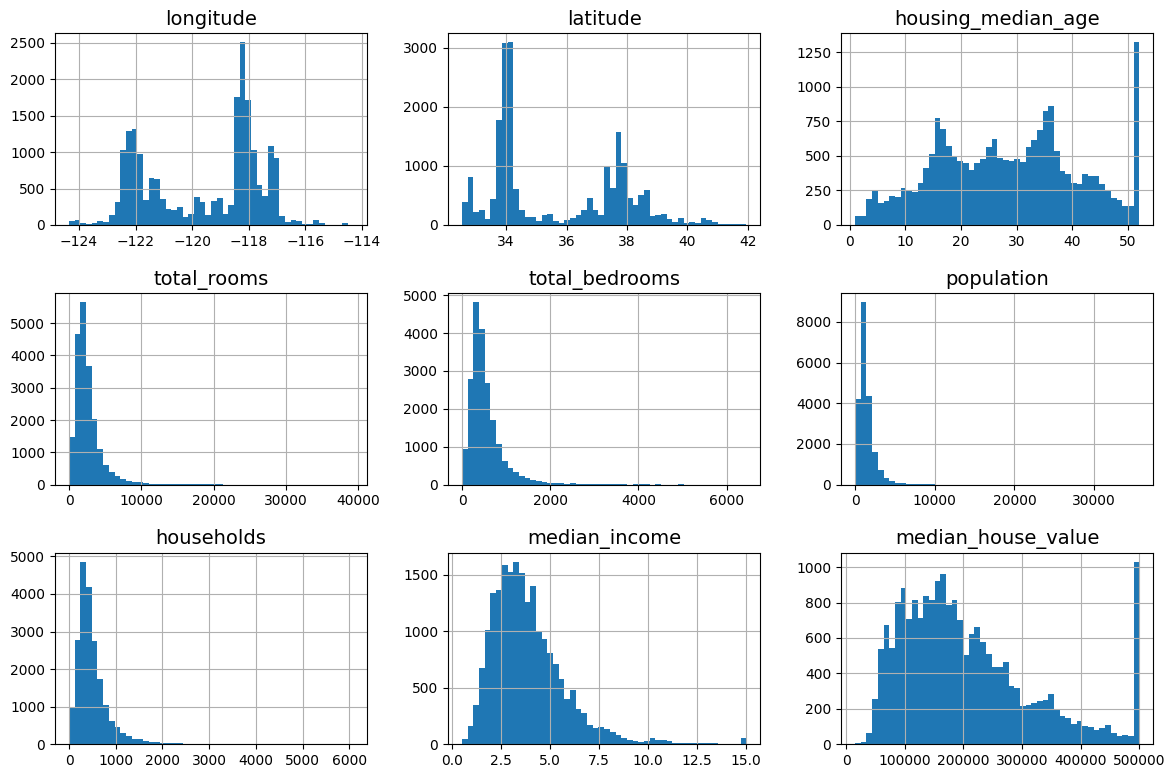

In [5]:
import matplotlib.pyplot as plt

# extra code – the next 5 lines define the default font sizes
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

housing.hist(bins=50, figsize=(12, 8))
save_fig("attribute_histogram_plots")  # extra code
plt.show()

Looking at these histograms, you notice a few things:

+ First, the median income attribute does not look like it is expressed in US dollars (USD). After checking with the team that collected the data, you are told that the data has been scaled and capped at 15 (actually, 15.0001) for higher median incomes, and at 0.5 (actually, 0.4999) for lower median incomes. The numbers represent roughly tens of thousands of dollars (e.g., 3 actually means about $30,000).
+ The housing median age and the median house value were also capped. The latter may be a serious problem since it is your target attribute (your labels). Your machine learning algorithms may learn that prices never go beyond that limit. You need to check with your client team (the team that will use your system’s output) to see if this is a problem or not. If they tell you that they need precise
predictions even beyond $500,000, then you have two options:
    - Collect proper labels for the districts whose labels were capped.
    - Remove those districts from the training set (and also from the test set, since your system should not be evaluated poorly if it predicts values beyond $500,000).
+ These attributes have very different scales. We will discuss this later.
+ Finally, many histograms are skewed right: they extend much farther to the right of the median than to the left. This may make it a bit harder for some machine learning algorithms to detect patterns. Later, you’ll try transforming these attributes to have more symmetrical and bell-shaped distributions.

## Create a Test Set

In [6]:
import numpy as np

def shuffle_and_split_data(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [7]:
train_set, test_set = shuffle_and_split_data(housing, 0.2)
len(train_set)

16512

In [8]:
len(test_set)

4128

In [9]:
np.random.seed(42)

*A method for maintaining a consistent train/test split even when the dataset is updated:* The method involves using each instance’s unique identifier to determine if it should be in the test set. This is done by computing a hash of the identifier and including the instance in the test set if the hash is less than or equal to 20% of the maximum hash value. This ensures that the test set remains consistent across multiple runs, even when the dataset is refreshed. The updated test set will contain 20% of the new instances, but will not include any instances that were previously in the training set. Here is a possible implementation:

In [10]:
from zlib import crc32

def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32

def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

Explanation for the code:

+ The `crc32` function from the `zlib` module in Python takes a byte string and returns a 32-bit hash value of that byte string.

+ `is_id_in_test_set(identifier, test_ratio)`: This function checks whether an `identifier` belongs to the test data set, based on the `test_ratio` ratio. To do this, the function uses the `crc32` function from the `zlib` module to calculate the hash value of the `identifier`. If the hash value is less than `test_ratio * 2**32`, then `identifier` is considered to belong to the test data set.

+ In the `is_id_in_test_set` function, `np.int64(identifier)` is used to ensure that the `identifier` is converted to numpy's int64 data type before being passed to the `crc32` function. The reason for this is that the `crc32` function requires the input to be a byte string. If `identifier` is not an integer, converting it to `np.int64` will ensure that it can be validly converted to a byte string. Additionally, using `np.int64` also ensures that the identifier will have the same data type on all platforms. This is important because the default data type of an integer can change depending on the platform (for example, 32-bit or 64-bit). By using `np.int64`, you ensure that the identifier will always be 64-bit, regardless of the platform.

Unfortunately, the housing dataset does not have an identifier column. The simplest solution is to use the row index as the ID:

In [11]:
housing_with_id = housing.reset_index()  # adds an `index` column
housing_with_id

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...,...
20635,20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


In [12]:
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "index")

If you use the row index as a unique identifier, you need to make sure that new data gets appended to the end of the dataset and that no row ever gets deleted. If this is not possible, then you can try to use the most stable features to build a unique identifier. For example, a district’s latitude and longitude are guaranteed to be stable for a few million years, so you could combine them into an ID like so:

In [13]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
housing_with_id

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,-122192.12
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,-122182.14
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,-122202.15
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,-122212.15
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,-122212.15
...,...,...,...,...,...,...,...,...,...,...,...,...
20635,20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND,-121050.52
20636,20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND,-121170.51
20637,20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND,-121180.57
20638,20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND,-121280.57


In [14]:
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "id")

Scikit-Learn provides a few functions to split datasets into multiple subsets in various ways. The simplest function is `train_test_split()`, which does pretty much the same thing as the `shuffle_and_split_data()` function we defined earlier

In [15]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [16]:
test_set["total_bedrooms"].isnull().sum()

44